# Time Series Classification using Random Forest

In [217]:
# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Machine Learning
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyClassifier

# Planetary Computer Tools
import pystac
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import odc
import toolz
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('**************')

#features extraction
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()


#Get vh_vv function

def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    
    box_size_deg = 0.0009 # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    #bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace,
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    
    
    
    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees

    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
    
    # Load the data using Open Data Cube
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale)
   
    # Calculate the mean of the data across the sample region
    mean = data.mean(dim=['latitude','longitude']).compute()
    
    # Calculate V
    v = mean.vv + mean.vh
    
    
    return v.values

def get_new_features(data,L):
    #data = 600 time series list of values
    
    
    new_features=[]
    if 'mean' in L:
        the_means=[]
        for col in data.columns:
            mean_v = float(np.mean(data[col]))
            the_means.append(mean_v)
        new_features.append(the_means)
    
    if 'std' in L:
        the_stds=[]
        for col in data.columns:
            sigma_v = float(np.std(data[col]))
            the_stds.append(sigma_v)
        new_features.append(the_stds)
    
    if 'CV' in L:
        the_CVs=[]
        for col in data.columns:
            mean_v = float(np.mean(data[col]))
            sigma_v = float(np.std(data[col]))
            CV_v = float(mean_v/sigma_v)
            the_CVs.append(CV_v)
        new_features.append(the_CVs)
    
    if 'max' in L:
        the_maxs=[]
        for col in data.columns:
            max_v = float(max(data[col]))
            the_maxs.append(max_v)
        new_features.append(the_maxs)
        
    if 'min' in L:
        the_mins=[]
        for col in data.columns:
            min_v = float(min(data[col]))
            the_mins.append(min_v)
        new_features.append(the_mins)
        
    if 'median' in L:
        the_medians=[]
        for col in data.columns:
            median_v = float(np.median(data[col]))
            the_medians.append(median_v)
        new_features.append(the_medians)
    
    if 'amplitude' in L:
        the_amplis=[]
        for col in data.columns:
            max_v = float(max(data[col]))
            min_v = float(min(data[col]))
            ampli_v = abs(max_v-min_v)
            the_amplis.append(ampli_v)
        new_features.append(the_amplis)
        
    if 'absolute energy' in L:
        the_abs_Es=[]
        for col in data.columns:
            abs_E_v = float(sum((data[col])**2))
            the_abs_Es.append(abs_E_v)
        new_features.append(the_abs_Es)
    
    if 'mean diff' in L:
        the_mean_diffs=[]
        col_1 = np.delete(data[col].values,0)
        col_2 = np.delete(data[col].values,len(data[col])-1)
        delta_v = col_1-col_2
        for col in data.columns:
            mean_delta_v = float(np.mean(delta_v))
            the_mean_diffs.append(mean_delta_v)
        new_features.append(the_mean_diffs)
        
    if 'autocorrelation lag 1' in L:
        the_auto_lag_1s=[]
        for col in data.columns: 
            the_auto=sm.tsa.acf(data[col])[1]
            the_auto_lag_1s.append(the_auto)
        new_features.append(the_auto_lag_1s)
    
    #median_delta_v = float(np.median(delta_v))
    #sum_delta_v = float(sum(abs(delta_v)))
    #dist_v = float(sum(np.sqrt(1+delta_v**2)))#signal distance 
    
    return np.transpose(pd.DataFrame(new_features,index=pd.Index(L)))
        
        
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

def anomaly_detection(list_v,crop_presence_data,treshold):
    if np.shape(list_v)[0]<np.shape(list_v)[1]:
        list_v_clean=np.transpose(list_v)
    to_drop=[]
    for i in range(np.shape(list_v_clean)[0]):
        for j in range(np.shape(list_v_clean)[1]):
            if abs(list_v_clean[j][i])>=treshold:
                to_drop.append(i)
    list_v_clean=list_v_clean.drop(index=list_v_clean.index[to_drop])
    crop_presence_data=crop_presence_data.drop(index=crop_presence_data.index[to_drop])
    list_v_clean=list_v_clean.reset_index(drop=True)
    crop_presence_data=crop_presence_data.reset_index(drop=True)
    return list_v_clean, crop_presence_data

def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    ### START CODE HERE ### 
    mu = 1/m*sum(X)
    var = 1/m*sum((X-mu)**2)
    
    ### END CODE HERE ### 
        
    return mu, var
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        ### START CODE HERE ### 
        predictions = (p_val < epsilon)
        fp = sum((predictions == 1) & (y_val == 0))
        tp = sum((predictions == 1) & (y_val == 1))
        fn = sum((predictions == 0) & (y_val == 1))
        
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        F1 = 2*prec*rec/(prec+rec)
        
        
        
        
        
        ### END CODE HERE ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1


def prep_extraction(list_v_clean):
    list_v_clean=np.transpose(list_v_clean)
    val_id=[1]*91
    val_time=[x for x in range(91)]*np.shape(list_v_clean)[1]
    all_values = []
    for column in list_v_clean:
        this_column_values = list_v_clean[column].tolist()
        all_values += this_column_values
    list_vf = pd.DataFrame(all_values)
    
    for i in range(1,np.shape(list_v_clean)[1]):
        val_id=val_id+[i+1]*91
    list_vf = pd.DataFrame(list_vf)
    list_vf.insert(loc=0,column='id',value=val_id)
    list_vf.insert(loc=1,column='time',value=val_time)
    return list_vf

def ts_extract(list_vf):
    extracted_features = extract_features(list_vf, column_id="id", column_sort="time")
    impute(extracted_features)
    extracted_features = extracted_features.reset_index(drop=True)
    return extracted_features
    

In [218]:
#Load data
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data['Class of Land'].loc[crop_presence_data['Class of Land']=="Rice"]=1.0
crop_presence_data['Class of Land'].loc[crop_presence_data['Class of Land']=="Non Rice"]=0.0

In [ ]:
 # Function call to extract VV,VH Values
time_slice = "2020-01-01/2020-12-31"
assests = ['vh','vv']
list_v = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    v=get_sentinel_data(coordinates,time_slice,assests)
    list_v.append(v)
list_v = np.transpose(pd.DataFrame(list_v))

In [219]:
#list_v.to_csv('list_vh+vv_mean10x10.csv', index=False)
list_v = pd.read_csv('list_vh+vv_mean10x10.csv')


In [220]:
#features_list=['mean','std','absolute energy','median','amplitude','max','min','CV','autocorrelation lag 1']
#list_vf=get_new_features(list_v,features_list)

In [118]:
#anomaly detection
list_v_clean,crop_presence_data=anomaly_detection(list_v,crop_presence_data,100)

In [221]:
#no anomaly
list_v_clean=np.transpose(list_v)

In [222]:
pd.set_option('display.max_rows', 10)
list_v_clean


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,0.22,0.18,0.13,0.10,0.15,0.05,0.05,0.06,0.10,0.21,0.11,0.20,0.17,0.14,0.18,0.21,0.27,0.22,0.26,0.28,0.28,0.08,0.16,0.13,0.09,0.12,0.24,0.24,0.23,0.23,0.13,0.16,0.11,0.10,0.09,0.07,0.06,0.06,0.07,0.08,0.08,0.10,0.14,0.10,0.14,0.15,0.16,0.15,0.24,0.42,0.37,0.28,0.24,0.17,0.19,0.21,0.03,0.12,0.06,0.14,0.05,0.05,0.23,0.35,0.32,0.26,0.14,0.15,0.08,0.08,0.10,0.07,0.05,0.05,0.06,0.11,0.18,0.11,0.13,0.11,0.09,0.20,0.15,0.17,0.28,0.21,0.15,0.06,0.04,0.04,0.11
1,0.25,0.40,0.17,0.30,0.29,0.11,0.05,0.09,0.10,0.20,0.17,0.18,0.22,0.23,0.14,0.18,0.26,0.20,0.22,0.16,0.38,0.04,0.04,0.14,0.02,0.02,0.10,0.21,0.16,0.30,0.30,0.34,0.09,0.12,0.17,0.07,0.07,0.10,0.07,0.08,0.14,0.16,0.14,0.11,0.11,0.14,0.10,0.16,0.36,0.37,0.34,0.29,0.22,0.13,0.13,0.16,0.03,0.15,0.14,0.02,0.08,0.07,0.23,0.38,0.38,0.18,0.13,0.14,0.09,0.09,0.13,0.07,0.06,0.06,0.21,0.15,0.16,0.08,0.10,0.12,0.14,0.21,0.23,0.27,0.16,0.19,0.12,0.06,0.10,0.13,0.02
2,0.18,0.34,0.11,0.10,0.16,0.08,0.06,0.07,0.15,0.22,0.22,0.17,0.15,0.12,0.18,0.15,0.22,0.19,0.29,0.28,0.29,0.19,0.24,0.06,0.11,0.12,0.20,0.37,0.28,0.25,0.20,0.28,0.17,0.10,0.09,0.08,0.13,0.11,0.11,0.09,0.11,0.11,0.16,0.23,0.16,0.18,0.21,0.20,0.28,0.41,0.27,0.25,0.27,0.16,0.15,0.26,0.03,0.10,0.02,0.16,0.06,0.06,0.37,0.42,0.33,0.20,0.18,0.19,0.10,0.09,0.11,0.06,0.05,0.04,0.13,0.14,0.14,0.09,0.10,0.09,0.08,0.12,0.16,0.31,0.31,0.34,0.25,0.33,0.09,0.16,0.16
3,0.19,0.20,0.11,0.09,0.10,0.06,0.05,0.06,0.18,0.20,0.14,0.19,0.20,0.14,0.22,0.25,0.25,0.26,0.25,0.21,0.18,0.15,0.14,0.08,0.11,0.18,0.07,0.33,0.28,0.33,0.16,0.18,0.12,0.12,0.14,0.08,0.06,0.07,0.09,0.07,0.14,0.09,0.16,0.17,0.15,0.15,0.16,0.14,0.27,0.36,0.37,0.30,0.21,0.11,0.06,0.07,0.02,0.05,0.04,0.16,0.04,0.04,0.18,0.37,0.30,0.27,0.15,0.15,0.11,0.09,0.11,0.08,0.05,0.05,0.12,0.17,0.17,0.10,0.11,0.11,0.14,0.17,0.14,0.15,0.30,0.24,0.11,0.03,0.05,0.08,0.10
4,0.18,0.35,0.13,0.09,0.15,0.06,0.06,0.11,0.26,0.22,0.14,0.18,0.20,0.20,0.18,0.24,0.30,0.27,0.30,0.24,0.14,0.08,0.12,0.09,0.03,0.03,0.25,0.47,0.46,0.26,0.12,0.15,0.14,0.11,0.12,0.08,0.05,0.09,0.09,0.10,0.14,0.13,0.14,0.10,0.11,0.13,0.08,0.28,0.29,0.35,0.13,0.30,0.38,0.04,0.10,0.03,0.12,0.03,0.03,0.15,0.35,0.33,0.31,0.20,0.23,0.12,0.13,0.18,0.06,0.06,0.08,0.18,0.22,0.14,0.20,0.23,0.17,0.22,0.13,0.17,0.35,0.13,0.35,0.35,0.07,0.22,0.25,0.07,0.09,0.09,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.38,0.31,0.42,0.39,0.30,0.42,0.37,0.32,0.42,0.36,0.28,0.34,0.40,0.28,0.37,0.40,0.34,0.41,0.40,0.28,0.37,0.38,0.29,0.43,0.36,0.29,0.39,0.35,0.29,0.38,0.44,0.36,0.40,0.37,0.29,0.44,0.46,0.30,0.41,0.35,0.35,0.38,0.42,0.29,0.45,0.41,0.32,0.39,0.39,0.27,0.35,0.45,0.38,0.41,0.37,0.29,0.38,0.34,0.26,0.37,0.39,0.25,0.44,0.32,0.30,0.42,0.44,0.28,0.42,0.34,0.30,0.40,0.37,0.26,0.40,0.35,0.37,0.29,0.37,0.35,0.32,0.38,0.37,0.24,0.35,0.35,0.29,0.38,0.31,0.27,0.40
596,0.38,0.32,0.50,0.40,0.32,0.42,0.39,0.34,0.44,0.42,0.34,0.37,0.41,0.32,0.38,0.40,0.34,0.40,0.41,0.33,0.42,0.40,0.31,0.47,0.41,0.33,0.43,0.38,0.31,0.42,0.49,0.43,0.39,0.42,0.30,0.47,0.47,0.33,0.40,0.35,0.37,0.39,0.41,0.34,0.50,0.47,0.34,0.41,0.43,0.29,0.36,0.47,0.34,0.45,0.40,0.32,0.47,0.40,0.30,0.42,0.45,0.28,0.45,0.39,0.35,0.45,0.43,0.31,0.44,0.40,0.35,0.45,0.42,0.33,0.46,0.41,0.42,0.32,0.40,0.40,0.39,0.43,0.38,0.25,0.38,0.39,0.30,0.42,0.37,0.33,0.40
597,0.36,0.31,0.48,0.38,0.33,0.40,0.40,0.32,0.40,0.41,0.34,0.36,0.36,0.30,0.38,0.35,0.31,0.42,0.44,0.34,0.40,0.41,0.30,0.49,0.40,0.31,0.43,0.36,0.26,0.37,0.50,0.41,0

In [223]:
#FEATURE EXTRACTION#
#Prepare data to use tsfresh
list_vf=prep_extraction(list_v_clean)


In [224]:
#Extract features using tsfresh

extracted_features = ts_extract(list_vf)


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


In [225]:
pd.set_option('display.max_columns', None)
extracted_features

0__variance_larger_than_standard_deviation  0__has_duplicate_max  \
0                                          0.00                  0.00   
1                                          0.00                  0.00   
2                                          0.00                  0.00   
3                                          0.00                  0.00   
4                                          0.00                  0.00   
..                                          ...                   ...   
595                                        0.00                  0.00   
596                                        0.00                  0.00   
597                                        0.00                  0.00   
598                                        0.00                  0.00   
599                                        0.00                  0.00   

     0__has_duplicate_min  0__has_duplicate  0__sum_values  0__abs_energy  \
0                    0.00              0.00          13.69           2.66   
1                    0.00              0.00          14.69           3.17   
2                    0.00              0.00          15.90           3.54   
3                    0.00              0.00          13.75           2.71   
4                    0.00              0.00          15.63           3.62   
..                    ...               ...            ...            ...   
595                  0.00              0.00          32.58          11.93   
596                  0.00              0.00          35.36          14.01   
597                  0.00              0.00          35.09          13.77   
598                  0.00              0.00          34.48          13.28   
599                  0.00              0.00          33.80          12.71   

     0__mean_abs_change  0__mean_change  0__mean_second_derivative_central  \
0                  0.05           -0.00                               0.00   
1                  0.07           -0.00                              -0.00   
2                  0.06           -0.00                              -0.00   
3                  0.05           -0.00                               0.00   
4                  0.08           -0.00                              -0.00   
..                  ...             ...                                ...   
595                0.07            0.00                               0.00   
596                0.08            0.00                               0.00   
597                0.07            0.00                               0.00   
598                0.06           -0.00                               0.00   
599                0.04            0.00                               0.00   

     0__median  0__mean  0__length  0__standard_deviation  \
0         0.14     0.15      91.00                   0.08   
1         0.14     0.16      91.00                   0.09   
2         0.16     0.17      91.00                   0.09   
3         0.14     0.15      91.00                   0.08   
4         0.14     0.17      91.00                   0.10   
..         ...      ...        ...                    ...   
595       0.37     0.36      91.00                   0.05   
596       0.40     0.39      91.00                   0.05   
597       0.39     0.39      91.00                   0.05   
598       0.37     0.38      91.00                   0.05   
599       0.37     0.37      91.00                   0.04   

     0__variation_coefficient  0__variance  0__skewness  0__kurtosis  \
0                        0.54         0.01         0.85         0.47   
1                        0.58         0.01         0.82         0.09   
2                        0.52         0.01         0.69        -0.16   
3                        0.55         0.01         0.82         0.19   
4                        0.59         0.01         0.81         0.13   
..                        ...          ...          ...          ...   
595                      0.15

In [ ]:
plt.plot(extracted_features['0__autocorrelation__lag_6'][113::])
#0__median  0__mean 0__c3__lag_1 0__autocorrelation__lag_1

In [226]:
#FEATURE SELECTION
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif
from scipy.stats import kendalltau
y=crop_presence_data ['Class of Land'].values
kendall_results=[[],[],[]]
for feature in list(extracted_features):
    kendall = kendalltau(extracted_features[feature], y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')
    kendall_results[0].append(feature)
    kendall_results[1].append(kendall.correlation)
    kendall_results[2].append(kendall.pvalue)
    
num_fe=20
kendall_corr_no_nan=[element for element in kendall_results[1] if str(element) != "nan"]
kendall_corr_sorted=np.sort(np.abs(kendall_corr_no_nan))[::-1]
features_sorted=[[],[],[]]
for f in range(num_fe):
    for i in range(len(kendall_results[1])):
        if kendall_corr_sorted[f]==kendall_results[1][i]:
            features_sorted[0].append(kendall_results[0][i])
            features_sorted[1].append(kendall_results[1][i])
            features_sorted[2].append(kendall_results[2][i])
            
#fs = SelectKBest(score_func=f_classif, k=20)
#fs.fit(extracted_features, y)
#features_filtered_anova=fs.transform(extracted_features)
#cols_idxs = fs.get_support(indices=True)
#features_filtered_anova = extracted_features.iloc[:,cols_idxs]
 

In [227]:
features_sorted


[['0__autocorrelation__lag_1',
  '0__partial_autocorrelation__lag_1',
  '0__autocorrelation__lag_1',
  '0__partial_autocorrelation__lag_1',
  '0__ar_coefficient__coeff_1__k_10',
  '0__autocorrelation__lag_2',
  '0__longest_strike_above_mean',
  '0__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
  '0__benford_correlation',
  '0__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
  '0__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
  '0__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4',
  '0__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
  '0__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6',
  '0__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
  '0__spkt_welch_density__coeff_5',
  '0__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4'],
 [0.7003367279775188,
  0.7003367279775188,
  0.7003367279775188,
  0.7003367279775188,
  0.6948166931369522,
  0.6792159109094821,
  0.603626542687873,
  0.5474

In [228]:
pd.set_option('display.max_rows', 10)
features_filtered_kendall = extracted_features[np.unique(features_sorted[0])]
features_filtered_kendall 

,"0__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",0__ar_coefficient__coeff_1__k_10,0__autocorrelation__lag_1,0__autocorrelation__lag_2,0__benford_correlation,"0__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","0__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","0__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","0__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","0__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","0__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","0__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",0__longest_strike_above_mean,0__partial_autocorrelation__lag_1,0__spkt_welch_density__coeff_5
0,0.00,0.68,0.68,0.42,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,0.68,0.12
1,0.00,0.46,0.51,0.24,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.51,0.16
2,0.00,0.54,0.57,0.34,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,0.57,0.15
3,0.00,0.68,0.67,0.38,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,0.67,0.19
4,0.00,0.48,0.47,0.14,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,0.47,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.00,-0.07,-0.29,-0.27,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,-0.29,0.00
596,0.00,-0.09,-0.28,-0.33,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,-0.28,0.00
597,0.00,-0.05,-0.17,-0.21,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,-0.17,0.00
598,0.00,0.06,-0.07,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,-0.07,0.01


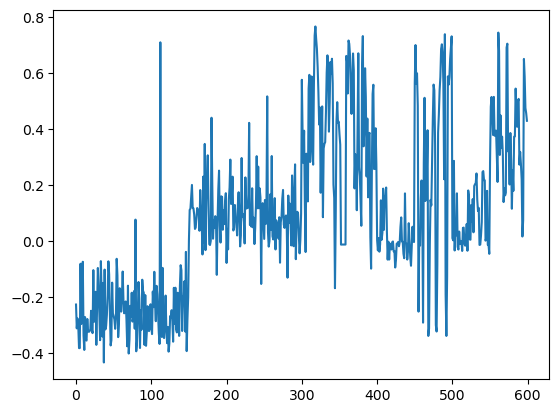

In [40]:
plt.plot(features_filtered_anova['0__autocorrelation__lag_6'])

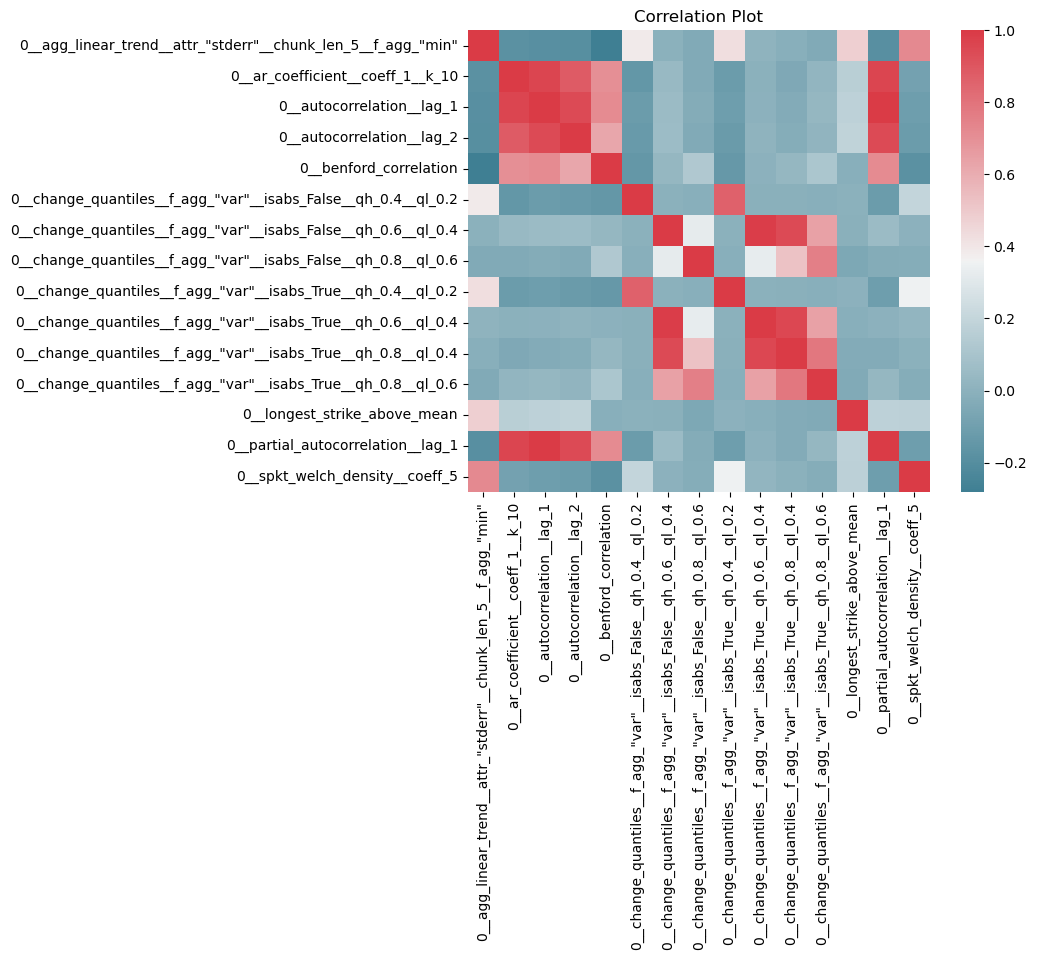

In [229]:
#features correlation
import seaborn as sns
corr_df=features_filtered_kendall   #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')

fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [38]:
#features_filtered_anova_f=features_filtered_anova.drop(labels=['0__partial_autocorrelation__lag_1'], axis=1)

In [261]:
pd.set_option('display.max_rows', 10)
features_filtered_anova_f=features_filtered_kendall[['0__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4','0__benford_correlation','0__autocorrelation__lag_1','0__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"','0__spkt_welch_density__coeff_5','0__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4','0__longest_strike_above_mean']]
features_filtered_anova_f

,"0__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4",0__benford_correlation,0__autocorrelation__lag_1,"0__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",0__spkt_welch_density__coeff_5,"0__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",0__longest_strike_above_mean
0,0.00,0.96,0.68,0.00,0.12,0.00,8.00
1,0.00,0.95,0.51,0.00,0.16,0.00,6.00
2,0.00,0.97,0.57,0.00,0.15,0.00,8.00
3,0.00,0.95,0.67,0.00,0.19,0.00,7.00
4,0.00,0.97,0.47,0.00,0.11,0.00,9.00
...,...,...,...,...,...,...,...
595,0.00,0.14,-0.29,0.00,0.00,0.00,5.00
596,0.00,0.03,-0.28,0.00,0.00,0.00,4.00
597,0.00,0.03,-0.17,0.00,0.00,0.00,5.00
598,0.00,0.04,-0.07,0.00,0.01,0.00,4.00


In [262]:
#Combine Latitude, Longitude and VV/VH
crop_data = combine_two_datasets(crop_presence_data,features_filtered_anova_f)

In [263]:
#Model building
#crop_data = crop_data[['vh','vv','Class of Land']]
X = crop_data.drop(columns=['Class of Land','Latitude and Longitude']).values
y = crop_data ['Class of Land'].values
y = np.asarray(y).astype("float64")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y,random_state=50)



In [264]:
#Feature scaling 1
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [265]:
# fit all models
pd.set_option('display.max_rows', None)
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:00<00:00, 29.32it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
KNeighborsClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
SVC                                1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
NuSVC                              1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
LabelSpreading                     1.00               1.00     1.00      1.00   
LabelPropagation                   1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
ExtraTreesClassifier        

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=50)


In [266]:
model=RandomForestClassifier(n_estimators= 500)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [278]:
from xgboost import XGBClassifier
n = int(len(X_train)*0.8)
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]
model = XGBClassifier(n_estimators = 483, learning_rate = 0.01,verbosity = 1, random_state = 55)
model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 50)
#model.fit(X_train,y_train)

[0]	validation_0-logloss:0.68372
[1]	validation_0-logloss:0.67454
[2]	validation_0-logloss:0.66559
[3]	validation_0-logloss:0.65681
[4]	validation_0-logloss:0.64814
[5]	validation_0-logloss:0.63969
[6]	validation_0-logloss:0.63129
[7]	validation_0-logloss:0.62309
[8]	validation_0-logloss:0.61500
[9]	validation_0-logloss:0.60715
[10]	validation_0-logloss:0.59933
[11]	validation_0-logloss:0.59172
[12]	validation_0-logloss:0.58427
[13]	validation_0-logloss:0.57687
[14]	validation_0-logloss:0.56962
[15]	validation_0-logloss:0.56252
[16]	validation_0-logloss:0.55552
[17]	validation_0-logloss:0.54862
[18]	validation_0-logloss:0.54184
[19]	validation_0-logloss:0.53526
[20]	validation_0-logloss:0.52868
[21]	validation_0-logloss:0.52225
[22]	validation_0-logloss:0.51593
[23]	validation_0-logloss:0.50971
[24]	validation_0-logloss:0.50363
[25]	validation_0-logloss:0.49759
[26]	validation_0-logloss:0.49165
[27]	validation_0-logloss:0.48584
[28]	validation_0-logloss:0.48008
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=483, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=55, ...)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'min_samples_split': [5,10,15,20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [130]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 200}

In [149]:
rfc=RandomForestClassifier(random_state=50, min_samples_split=5, max_features='auto', n_estimators= 200, max_depth=4, criterion='gini')
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features='auto', min_samples_split=5,
                       n_estimators=200, random_state=50)

In [267]:
#Out sample evaluation
outsample_predictions = model.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
#print(classification_report(y_test, outsample_predictions))
#plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

Accuracy 100.00%


In [268]:
#Submission test 
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')


In [ ]:
    
## Get Sentinel-1-RTC Data
time_slice = "2020-01-01/2020-12-31"
assests = ['vh','vv']
list_vs = []
for coordinates in tqdm(test_file['id']):
    vs=get_sentinel_data(coordinates,time_slice,assests)
    list_vs.append(vs)
submission_v_data = np.transpose(pd.DataFrame(list_vs))


In [269]:
#submission_v_data.to_csv('submission_vh+vv_ampli_mean10x10.csv', index=False)
submission_v_data= pd.read_csv('submission_vh+vv_ampli_mean10x10.csv')

In [238]:
#submission_vh_vv_data = submission_vh_vv_data.drop(columns=[8,9,10])
pd.set_option('display.max_rows', 10)
submission_v_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,0.07,0.09,0.03,0.01,0.11,0.01,0.33,0.02,0.01,0.14,0.49,0.17,0.14,0.32,0.14,0.01,0.10,0.24,0.24,0.06,0.09,0.27,0.09,0.27,0.07,0.07,0.13,0.30,0.02,0.19,0.58,0.06,0.07,0.04,0.09,0.16,0.33,0.01,0.26,0.07,0.07,0.01,0.16,0.08,0.08,0.35,0.30,0.04,0.08,0.12,0.62,0.18,0.27,0.31,0.23,0.31,0.14,0.30,0.22,0.14,0.07,0.02,0.22,0.01,0.27,0.01,0.02,0.07,0.32,0.41,0.05,0.01,0.30,0.10,0.17,0.01,0.16,0.09,0.27,0.29,0.28,0.29,0.40,0.23,0.07,0.30,0.01,0.30,0.25,0.15,0.29,0.26,0.21,0.57,0.20,0.25,0.08,0.47,0.08,0.14,0.25,0.02,0.14,0.46,0.13,0.40,0.01,0.29,0.47,0.15,0.07,0.29,0.28,0.18,0.05,0.01,0.40,0.06,0.01,0.01,0.17,0.29,0.08,0.03,0.31,0.14,0.18,0.28,0.25,0.05,0.12,0.01,0.37,0.11,0.28,0.02,0.08,0.28,0.30,0.03,0.24,0.08,0.01,0.22,0.03,0.02,0.01,0.08,0.16,0.22,0.16,0.36,0.09,0.28,0.03,0.07,0.01,0.18,0.24,0.03,0.37,0.07,0.33,0.35,0.08,0.36,0.02,0.18,0.06,0.32,0.01,0.27,0.08,0.32,0.16,0.09,0.08,0.06,0.28,0.06,0.18,0.17,0.26,0.07,0.07,0.02,0.25,0.35,0.41,0.01,0.08,0.09,0.18,0.31,0.03,0.36,0.07,0.07,0.08,0.23,0.01,0.01,0.16,0.20,0.11,0.31,0.16,0.01,0.27,0.27,0.22,0.12,0.02,0.03,0.08,0.01,0.24,0.07,0.01,0.08,0.24,0.82,0.85,0.07,0.29,0.27,0.30,0.04,0.02,0.25,0.29,0.02,0.29,0.29,0.20,0.26,0.07,0.63,0.27,0.02,0.27,0.03,0.06,0.28,0.01,0.01,0.02,0.01,0.08,0.06
1,0.03,0.09,0.20,0.02,0.13,0.03,0.27,0.36,0.02,0.20,0.62,0.04,0.10,0.25,0.02,0.02,0.09,0.37,0.28,0.06,0.09,0.32,0.19,0.27,0.07,0.07,0.19,0.30,0.68,0.27,0.80,0.22,0.07,0.03,0.09,0.15,0.37,0.02,0.15,0.17,0.07,0.03,0.49,0.05,0.19,0.20,0.10,0.12,0.06,0.17,0.48,0.49,0.27,0.23,0.32,0.32,0.03,0.24,0.23,0.02,0.06,0.19,0.21,0.01,0.09,0.02,0.01,0.05,0.25,0.34,0.04,0.02,0.28,0.03,0.34,0.01,0.17,0.09,0.24,0.28,0.27,0.27,0.77,0.27,0.04,0.13,0.02,0.25,0.41,0.05,0.28,0.17,0.26,0.43,0.36,0.29,0.08,0.31,0.07,0.29,0.32,0.02,0.03,0.69,0.09,0.29,0.02,0.62,0.08,0.09,0.02,0.73,0.33,0.08,0.27,0.02,0.41,0.06,0.01,0.03,0.09,0.28,0.13,0.03,0.32,0.40,0.08,0.25,0.31,0.04,0.10,0.02,0.78,0.10,0.30,0.27,0.09,0.29,0.29,0.02,0.26,0.04,0.02,0.23,0.24,0.03,0.02,0.12,0.15,0.31,0.33,0.96,0.06,0.33,0.07,0.06,0.01,0.15,0.33,0.02,0.31,0.08,0.38,0.27,0.05,0.25,0.69,0.20,0.04,0.33,0.02,0.24,0.07,0.23,0.02,0.08,0.07,0.06,0.35,0.07,0.38,0.22,0.43,0.07,0.06,0.07,0.45,0.23,0.40,0.02,0.17,0.13,0.22,0.26,0.21,0.28,0.05,0.08,0.07,0.29,0.68,0.02,0.40,0.14,0.15,0.37,0.04,0.02,0.22,0.25,0.42,0.09,0.11,0.20,0.17,0.02,0.38,0.17,0.02,0.08,0.42,0.07,0.04,0.11,0.23,0.30,0.27,0.09,0.02,0.25,0.31,0.02,0.21,0.47,0.24,0.27,0.03,1.02,0.30,0.14,0.26,0.03,0.08,0.36,0.02,0.02,0.02,0.01,0.21,0.07
2,0.04,0.05,0.11,0.01,0.07,0.02,0.37,0.36,0.01,0.08,0.60,0.32,0.24,0.35,0.01,0.01,0.07,0.27,0.22,0.04,0.04,0.29,0.02,0.30,0.04,0.15,0.08,0.30,0.11,0.10,0.51,0.29,0.09,0.04,0.04,0.14,0.37,0.01,0.26,0.16,0.06,0.02,0.16,0.07,0.39,0.30,0.32,0.05,0.07,0.16,0.53,0.18,0.25,0.25,0.33,0.30,0.25,0.09,0.22,0.01,0.04,0.09,0.10,0.01,0.28,0.02,0.01,0.06,0.29,0.36,0.04,0.01,0.31,0.10,0.19,0.01,0.07,0.09,0.31,0.32,0.29,0.34,0.40,0.21,0.05,0.32,0.01,0.22,0.30,0.33,0.26,0.24,0.23,0.53,0.28,0.32,0.05,0.43,0.06,0.14,0.30,0.02,0.02,0.12,0.06,0.36,0.01,0.31,0.02,0.15,0.02,0.27,0.30,0.12,0.25,0.01,0.36,0.04,0.01,0.02,0.2

In [270]:
#submission_v_data_f=get_new_features(submission_v_data,['mean','std','absolute energy','median','amplitude','max','min','autocorrelation lag 1'])
submission_v_data_f=prep_extraction(np.transpose(submission_v_data))

In [271]:
submission_extracted_features = ts_extract(submission_v_data_f)

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


In [272]:
cols = features_filtered_anova_f.columns
submission_extracted_features=submission_extracted_features[list(cols)]

In [273]:
#submission_v_data_f=submission_v_data_f.drop(labels=[7], axis=1)

In [279]:
# Feature Scaling 
submission_v_data_f #= submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_extracted_features)

#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)
final_prediction_series.loc[final_prediction_series==0.]='Non Rice'
final_prediction_series.loc[final_prediction_series==1.]='Rice'
    
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series.values})
#Displaying the sample submission dataframe
pd.set_option('display.max_rows', 10)
display(submission_df)


,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [243]:
#Submission file
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)